/home/spartan/.local/lib/python3.5/site-packages/pandas/core/series.py:2849: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


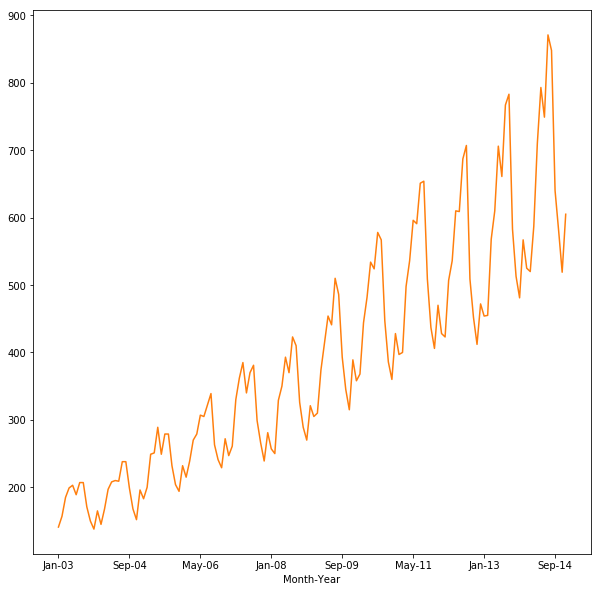

In [25]:
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('Tractor-Sales.csv', header=0)
series.plot(figsize=(10,10))
pyplot.show()

Now from this data we need to eliminate trend so for that we gonna use differencing that is asically subtracting previous observation from current observation.
Differencing is one of the most commonly used mechanisms for extraction of trends. Here, the original series is subtracted from it’s lagged series e.g. November’s sales values are subtracted from October’s values to produce trend-less residual series. 
Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.
Reference https://machinelearningmastery.com/difference-time-series-dataset-python/
          http://ucanalytics.com/blogs/arima-models-manufacturing-case-study-example-part-3/

In [26]:
diff=series.diff() #differencing to make it stationary on mean

In [29]:
series.head()

Month-Year
Jan-03    141
Feb-03    157
Mar-03    185
Apr-03    199
May-03    203
Name: Number of Tractor Sold, dtype: int64

In [31]:
diff.head(10)

Month-Year
Jan-03     NaN
Feb-03    16.0
Mar-03    28.0
Apr-03    14.0
May-03     4.0
Jun-03   -14.0
Jul-03    18.0
Aug-03     0.0
Sep-03   -36.0
Oct-03   -21.0
Name: Number of Tractor Sold, dtype: float64

In [32]:
diff.plot()

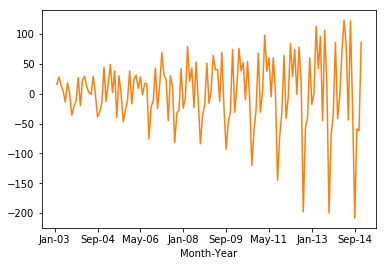

In [33]:
pyplot.show() #not stationary on variance

1-order differenced dataset,you can see trend is removed from this graph

the above series is not stationary on variance i.e. variation in the plot is increasing as we move towards the right of the chart. We need to make the series stationary on variance to produce reliable forecasts through ARIMA models.One of the best ways to make a series stationary on variance is through transforming the original series through log transform. We will go back to our original tractor sales series and log transform it to make it stationary on variance. 

In [188]:
import math         #Converting data to log data to make it stationary on variance
logseries=[]
for i in range(len(series)):
    logseries.append(math.log10(series[i]))
    

In [189]:
logseries[1]

2.1958996524092336

In [49]:
series[1]

157

In [50]:
math.log10(157)

2.1958996524092336

In [51]:
#Now we need to make this stationary on mean too so we gonna do differencing
diff1=Series(logseries).diff()

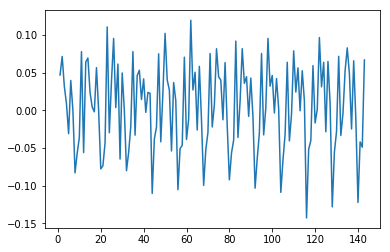

In [53]:
diff1.plot()
pyplot.show()

Now we gonna create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR(Auto regressive) and MA(Moving average) components in the residuals.

ACF - Auto correlation function, as the word suggests, auto-correlation, means it is really correlation on itself. With time series we just have a single stream of values, or in other words there is just the X no Y. So suppose your time series is like this X = 3,5,6,6,7,4,5,6,7,2,3,4,… correlation between 4 and 3, 3 and 2, 2 and 7 (lag 1) will be say y1; correlation between 4 and 2, 3 and 7, 2 and 6 (lag 2) will be say y2; and so on at lags 3 = y3, lag 4 = y4.
What interests us is the pattern or lack of pattern in y1,y2,y3… This plot is called auto correlation function. We look for 1. is the curve decaying exponentially or 2. does the curve cut off suddenly
PACF - Partial auto correlation function, as the word suggests, is partial not complete. Here again we are plot the correlations at various lags 1,2,3 BUT after adjusting for the effects of intermediate numbers.
The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.
What is the use of ACF and PACF? - The pattern of the acf/pacf plot gives us an idea towards which model could be the best fit for doing prediction.


Below we have plotted auto correlation graph using all three different methods.

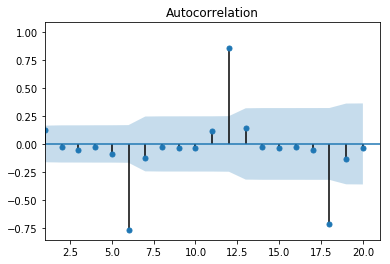

In [110]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diff1[1:],lags=20)
pyplot.xlim(xmin=1)

pyplot.show()

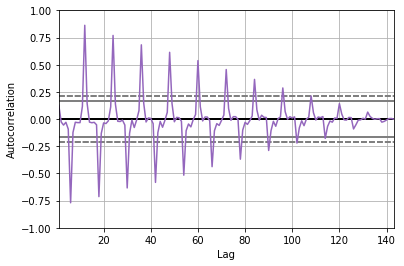

In [107]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(diff1[1:])
pyplot.show()

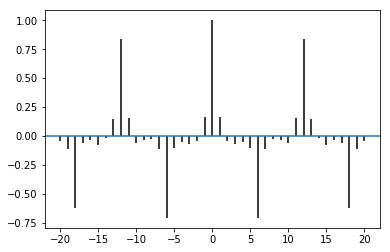

In [102]:
pyplot.acorr(diff[1:],maxlags=20)
pyplot.show()

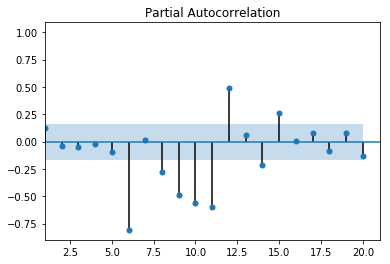

In [111]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diff1[1:],lags=20)
pyplot.xlim(xmin=1)

pyplot.show()

Since, there are enough spikes in the plots outside the insignificant zone (dotted horizontal lines) we can conclude that the residuals are not random. This implies that there is juice or information available in residuals to be extracted by AR and MA models. Also, there is a seasonal component available in the residuals at the lag 12 (represented by spikes at lag 12). This makes sense since we are analyzing monthly data that tends to have seasonality of 12 months because of patterns in tractor sales.
reference https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

In [114]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2 for fitting arima model
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#sarimax is package to fit arima model in statsmodels
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection.
When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [115]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [116]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [129]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
            mod1 = sm.tsa.statespace.SARIMAX(logseries,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod1.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:676.4456986283035
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:483.6097687925792
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-369.1622983976859
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-377.75917578000445
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-565.9206367619985
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-562.5538938200411


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-426.3115626674921
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-500.64136141666586
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:483.54368848271383
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:307.208500371417
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-470.702538984983
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-444.73438289014746
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-616.9379817407103
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-613.3655520069276


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-471.27984257494836


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-536.4790887985589
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-410.89710178067253
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-479.48688156128446
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-648.63731970802
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-618.4210285571166
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-654.5201958723732
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-679.1588472827427
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-613.4875987693572
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-610.3875675089546
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-408.920453150711
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-475.10401634994594
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-658.4678325187464
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-631.0607024891272
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-668.8350999231805
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-688.9956857474765
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-636.4199219728293
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-624.7252501969651
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-412.720698

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-655.573466440549
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-622.7705087364202
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-665.4553185562836
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-691.4913449805895


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-613.6171348756134
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-614.9648797858194
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-409.6359944396513
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-393.53341416696867
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:-663.7545503044762
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-634.3219583505269


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-671.2485067561772
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-695.7856829431055
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-635.3920849571699
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-629.1393942369551
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-411.35919261572616
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-478.2155345976779
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:-663.8757445917937
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-634.9425254653612
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-663.2119333193762


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-693.1594317958502


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-629.1736205538747
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-627.5195639874224
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-406.9425997039244
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-479.4965547941463
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-655.8090189348288
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-629.2836121627871
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-661.2491366074423


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-686.8028996716962


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-629.1454296300701


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-622.8180170997925


Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model:

In [130]:
mod = sm.tsa.statespace.SARIMAX(logseries,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4273      0.075     -5.703      0.000      -0.574      -0.280
ma.S.L12      -0.5475      0.098     -5.609      0.000      -0.739      -0.356
sigma2         0.0003   2.76e-05      9.087      0.000       0.000       0.000


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

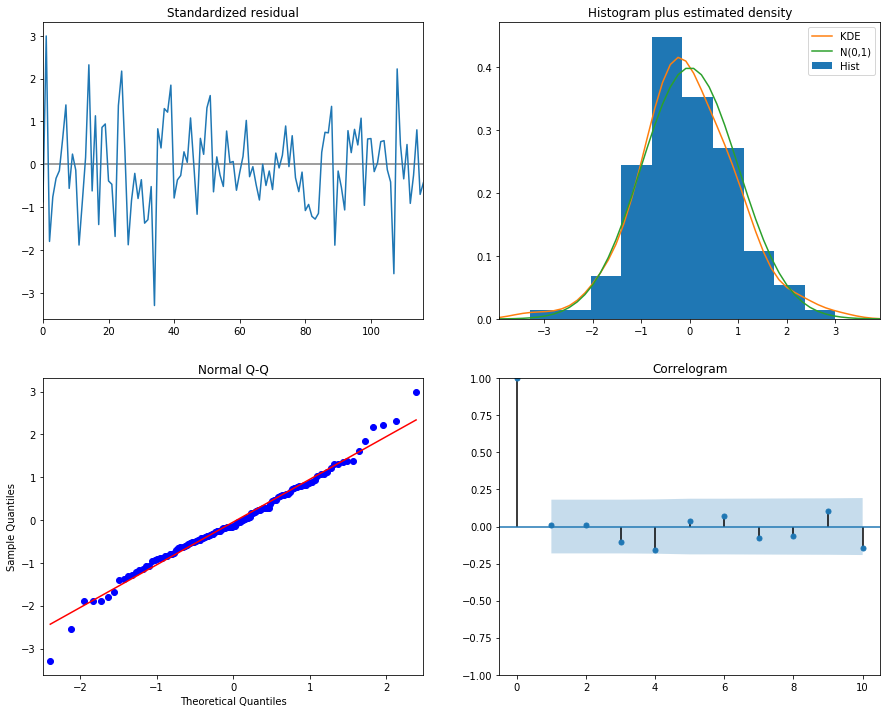

In [133]:
results.plot_diagnostics(figsize=(15, 12))
pyplot.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

    In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

    The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

    The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
    
Since there are no spikes outside the insignificant zone for  ACF plot we can conclude that residuals are random with no information or juice in them. Hence our ARIMA model is working fine.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Now we gonna do validation to check accuracy basically dividing data to training and testing and calculating accuracy on test data.
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [150]:
#Validation
from sklearn.metrics import mean_squared_error
X = logseries
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model2 = sm.tsa.statespace.SARIMAX(history, order=(0,1,1),seasonal_order=(0, 1, 1, 12))
    model_fit2 = model2.fit(disp=0)
    output = model_fit2.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (10**yhat, 10**obs))



predicted=435.512547, expected=428.000000
predicted=398.569278, expected=397.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=409.711426, expected=400.000000
predicted=493.709775, expected=498.000000
predicted=536.952487, expected=536.000000
predicted=590.158723, expected=596.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=570.070845, expected=591.000000
predicted=651.958624, expected=651.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=639.114550, expected=654.000000
predicted=516.042495, expected=509.000000
predicted=447.913411, expected=437.000000
predicted=408.691062, expected=406.000000
predicted=488.845463, expected=470.000000
predicted=442.078483, expected=428.000000
predicted=441.870513, expected=423.000000
predicted=529.794962, expected=507.000000
predicted=555.577803, expected=536.000000
predicted=599.484997, expected=610.000000
predicted=591.271655, expected=609.000000
predicted=670.181314, expected=687.000000
predicted=675.090638, expected=707.000000
predicted=548.981177, expected=509.000000
predicted=453.360706, expected=452.000000
predicted=419.645719, expected=412.000000
predicted=489.651999, expected=472.000000
predicted=439.708641, expected=454.000000
predicted=450.516979, expected=455.000000
predicted=551.916275, expected=568.000000
predicted=601.635526, expected=610.000000
predicted=680.069172, expected=706.000000
predicted=687.213212, expected=661.000000
predicted=749.330810, expected=767

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=528.243964, expected=520.000000
predicted=643.623053, expected=587.000000
predicted=650.268275, expected=710.000000
predicted=780.400754, expected=793.000000
predicted=759.115584, expected=749.000000
predicted=856.640528, expected=871.000000
predicted=877.180159, expected=848.000000
predicted=645.708658, expected=640.000000
predicted=564.015803, expected=581.000000
predicted=532.596654, expected=519.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=614.418970, expected=605.000000


In [151]:
test1=[]
prediction1=[]
for i in range(len(test)):
    test1.append(10**test[i])
    prediction1.append(10**predictions[i])

Test MSE: 367.951


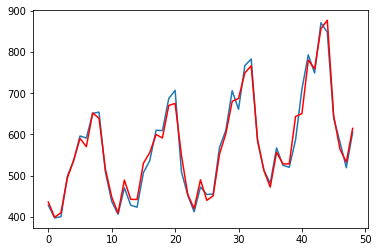

In [152]:
error = mean_squared_error(test1, prediction1)
print('Test MSE: %.3f' % error)
pyplot.plot(test1)
pyplot.plot(prediction1, color='red')
pyplot.show()

Finally we find out and plot predictions for next 3 years or 36 months

In [194]:
sw=results.forecast(steps=36) #results is model we already trained on logseries data,we want to predict for next 36 months so steps=36

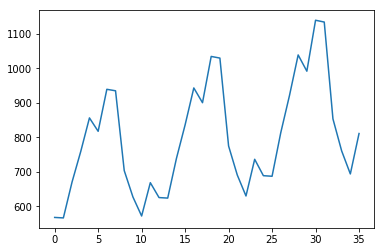

In [196]:
prediction_list=[]
for i in range(len(sw)):
    prediction_list.append(10**sw[i])
    
pyplot.plot(prediction_list)
pyplot.show()

In [197]:
prediction_list

[568.057157003915,
 566.6767941432618,
 670.776607473525,
 759.3402248944329,
 856.4849415668324,
 817.6608333877934,
 939.3819755774844,
 935.0623359523847,
 703.7779819306429,
 627.3594391589729,
 572.240105665835,
 668.7678401436658,
 625.6430963207597,
 624.1228012526715,
 738.7755764801997,
 836.317197321362,
 943.3098134353493,
 900.5499697232515,
 1034.61040950173,
 1029.8528729110626,
 775.1224156030279,
 690.9570580742986,
 630.2500851075877,
 736.5631733856428,
 689.0667235641038,
 687.3923108716617,
 813.667838625684,
 921.0975944711679,
 1038.9364260107063,
 991.841867499503,
 1139.4924825881392,
 1134.252657886091,
 853.6992838594989,
 761.0017898873297,
 694.1407389052857,
 811.2311564972716]